In [216]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium

from sklearn.ensemble import RandomForestClassifier

#basic libraries
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

In [217]:
#calculate variance inflation factor
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [218]:
def feature_importances (model, title):
    model.fit(X, y)
    features= X.columns
    importances = np.round(model.feature_importances_,3) 
    indices = np.argsort(importances)
    num_features = len(features)
    fig, ax = plt.subplots(figsize=(10,10)) 
    plt.barh(range(num_features), importances[indices[-num_features:]],  align='center', color =  '#66c2a5')
    plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance' + title)

plt.show()

In [219]:
def distribution_checker (data, xlabel):
  grouped = data.groupby([xlabel, 'status_group'])['id'].count().reset_index()
  pivot = grouped.pivot_table(index = xlabel, columns = 'status_group', fill_value = 0)
  mi=pivot.columns
  mi.tolist()
  ind = pd.Index([ str(e[1])  for e in mi.tolist()])
  pivot.columns = ind
  pivot['nr_pumps'] = pivot['functional'] +pivot['functional needs repair'] +pivot['non functional']
  pivot['all_pumps'] = pivot['nr_pumps'].sum()
  pivot['perc_total_pumps'] =((pivot['nr_pumps']/pivot['all_pumps'])*100).round(1)
  pivot['perc_functional'] = ((pivot['functional']/pivot['nr_pumps'])*100).round(1)
  pivot['perc_non_functional'] = ((pivot['non functional']/pivot['nr_pumps'])*100).round(1)
  pivot['perc_functional_needs_repair'] = ((pivot['functional needs repair']/pivot['nr_pumps'])*100).round(1)
  pivot = pivot.drop(['functional', 'functional needs repair', 'non functional', 'all_pumps'], axis=1)
  return(pivot)

In [220]:
train_df = pd.read_csv("final_df.csv")

full_df = pd.read_csv("preselection_noencoding_df.csv").drop('Unnamed: 0', axis=1)

train_base_df = pd.read_csv("project/data/train/features.csv", parse_dates = ['date_recorded' ],  na_values = [0, '0'])
labels = pd.read_csv("project/data/train/labels.csv")
original_df = pd.merge(labels, train_base_df, on='id')

/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_30285/3004910338.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("final_df.csv")
/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_30285/3004910338.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv("preselection_noencoding_df.csv").drop('Unnamed: 0', axis=1)


# Question 1

In [221]:
train_df['region'] = full_df['region']

In [222]:
train_df['region'].unique()

array(['Iringa', 'Mara', 'Manyara', 'Mtwara', 'Kagera', 'Tanga',
       'Shinyanga', 'Tabora', 'Pwani', 'Ruvuma', 'Kilimanjaro', 'Rukwa',
       'Mwanza', 'Kigoma', 'Lindi', 'Dodoma', 'Arusha', 'Mbeya',
       'Singida', 'Morogoro', 'Dar es Salaam'], dtype=object)

Accuracy: 0.906 (0.012)
Accuracy: 0.771 (0.023)
Accuracy: 0.845 (0.034)
Accuracy: 0.860 (0.022)
Accuracy: 0.764 (0.013)
Accuracy: 0.806 (0.036)
Accuracy: 0.785 (0.015)
Accuracy: 0.802 (0.028)
Accuracy: 0.823 (0.014)
Accuracy: 0.867 (0.024)
Accuracy: 0.819 (0.016)
Accuracy: 0.785 (0.031)
Accuracy: 0.809 (0.021)
Accuracy: 0.697 (0.026)
Accuracy: 0.825 (0.033)
Accuracy: 0.838 (0.025)
Accuracy: 0.774 (0.019)
Accuracy: 0.770 (0.020)
Accuracy: 0.864 (0.020)
Accuracy: 0.785 (0.017)
Accuracy: 0.912 (0.028)


/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_30285/3564241402.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10,10))


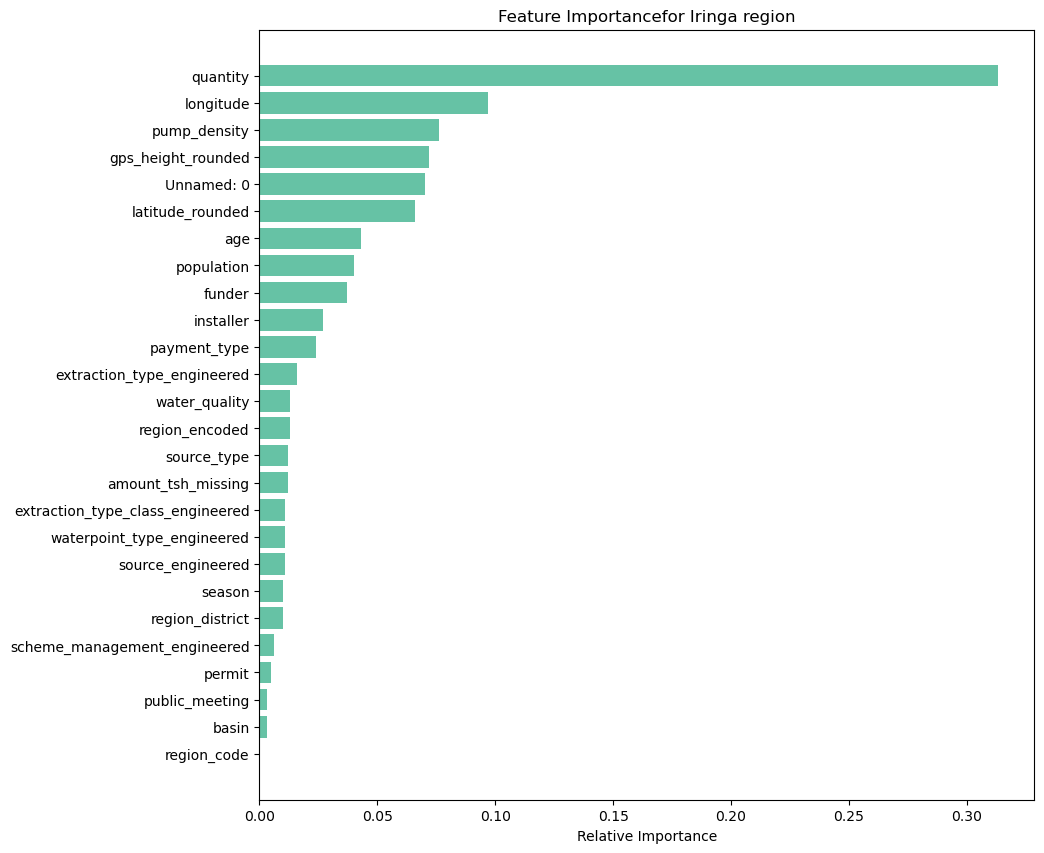

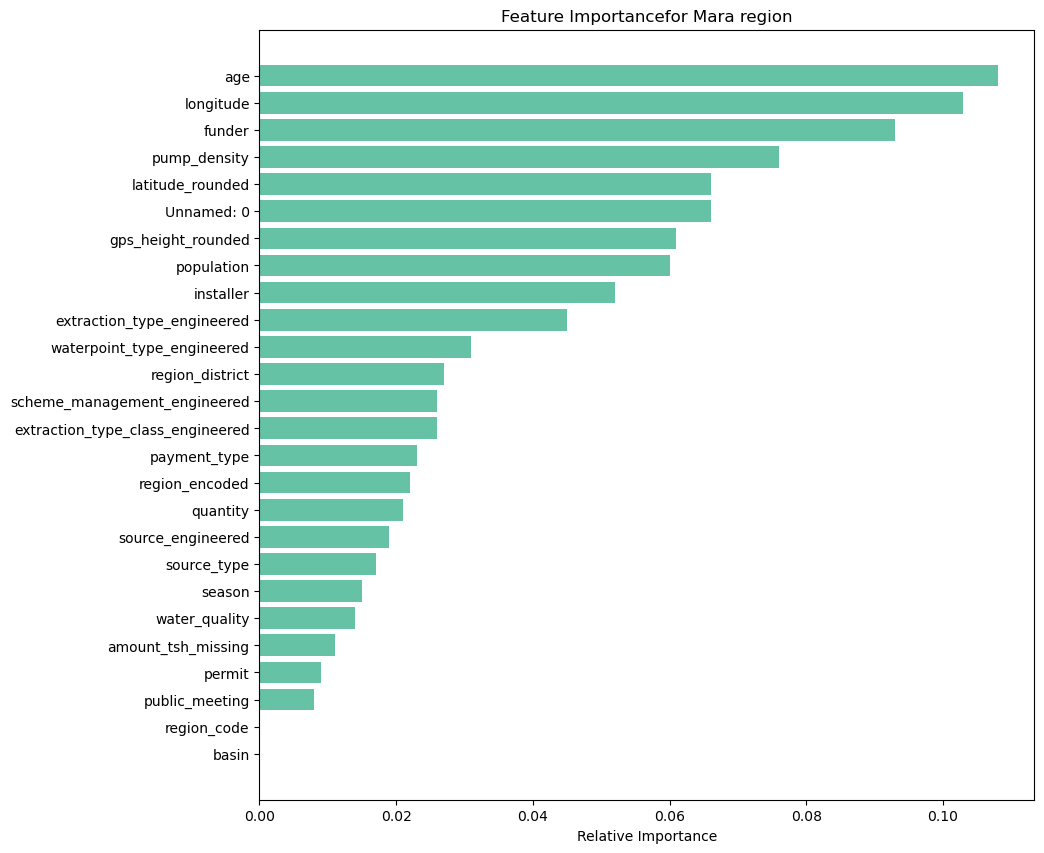

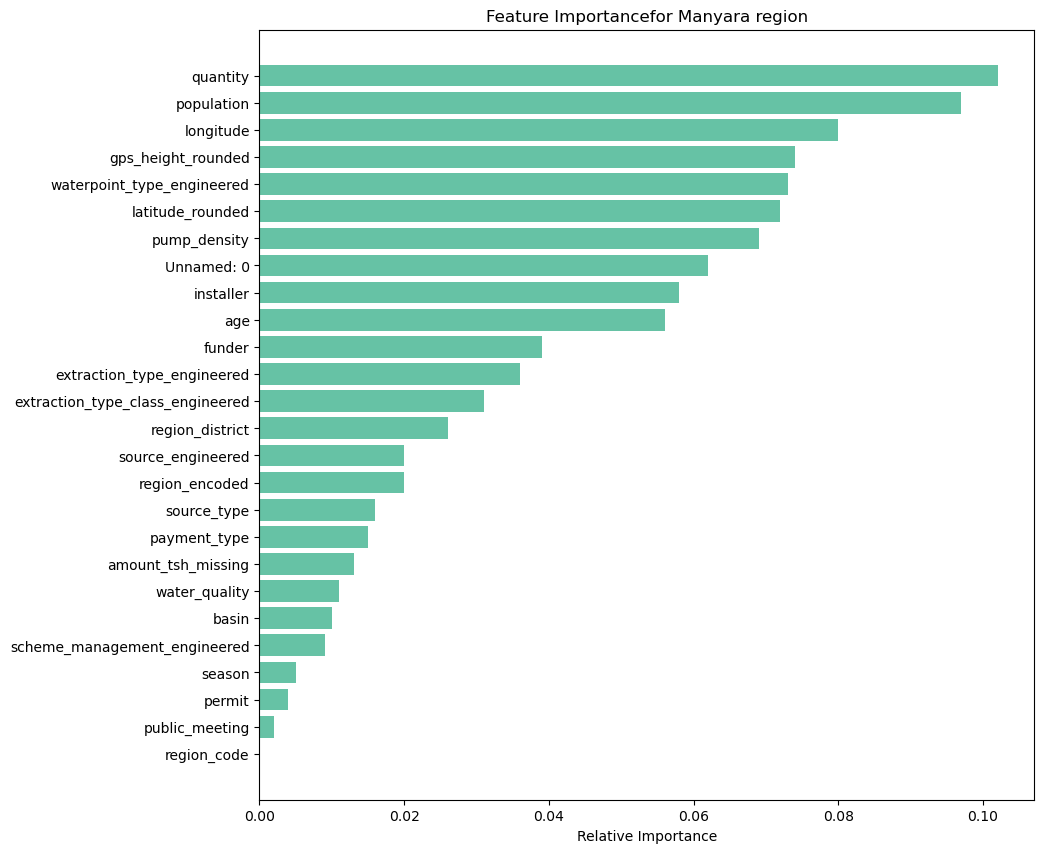

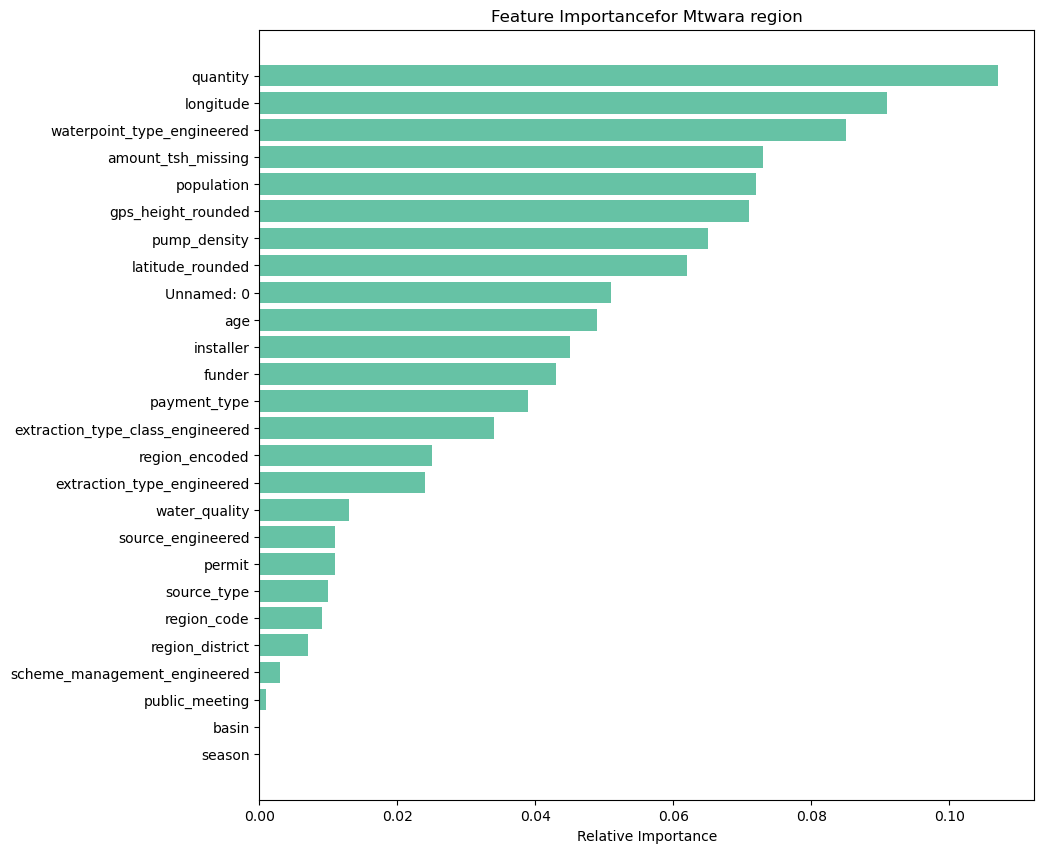

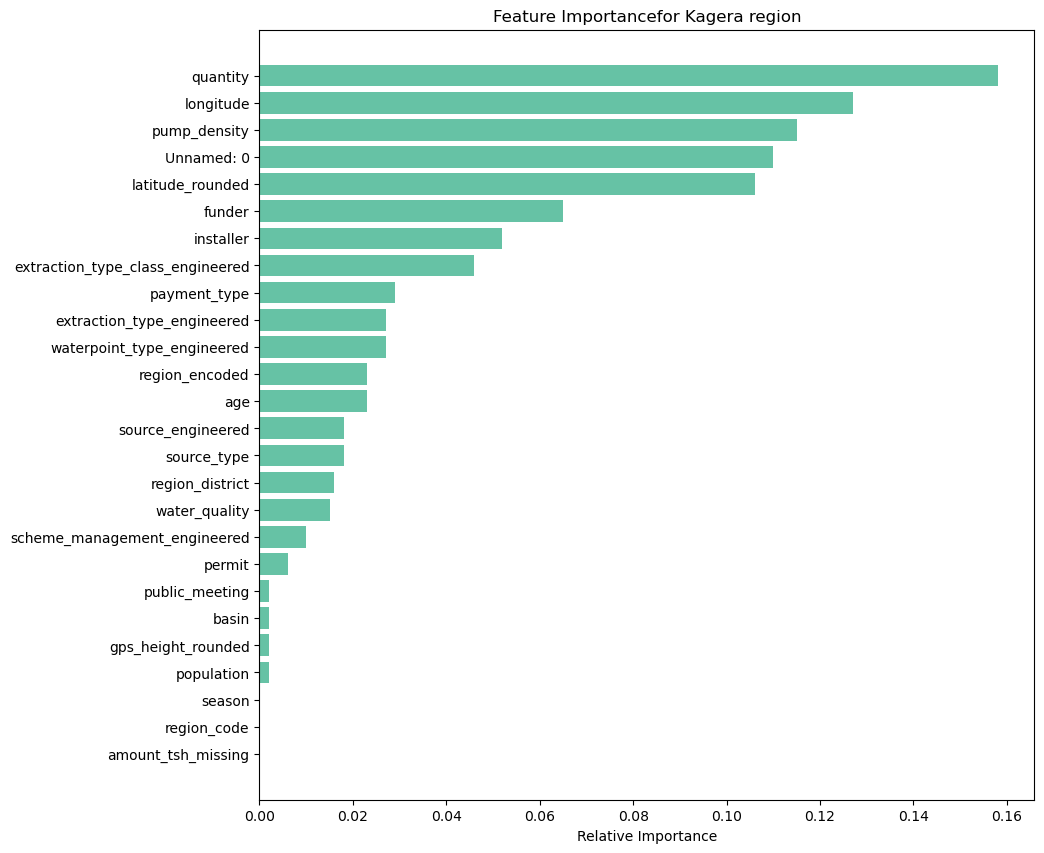

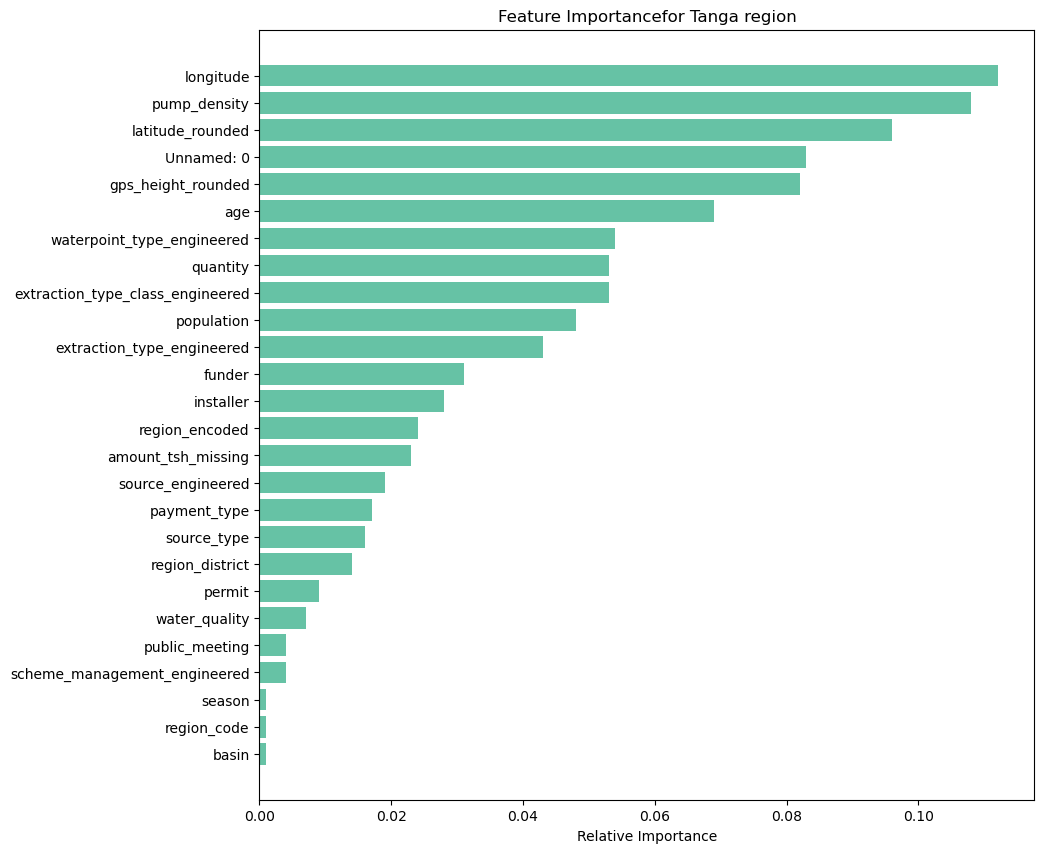

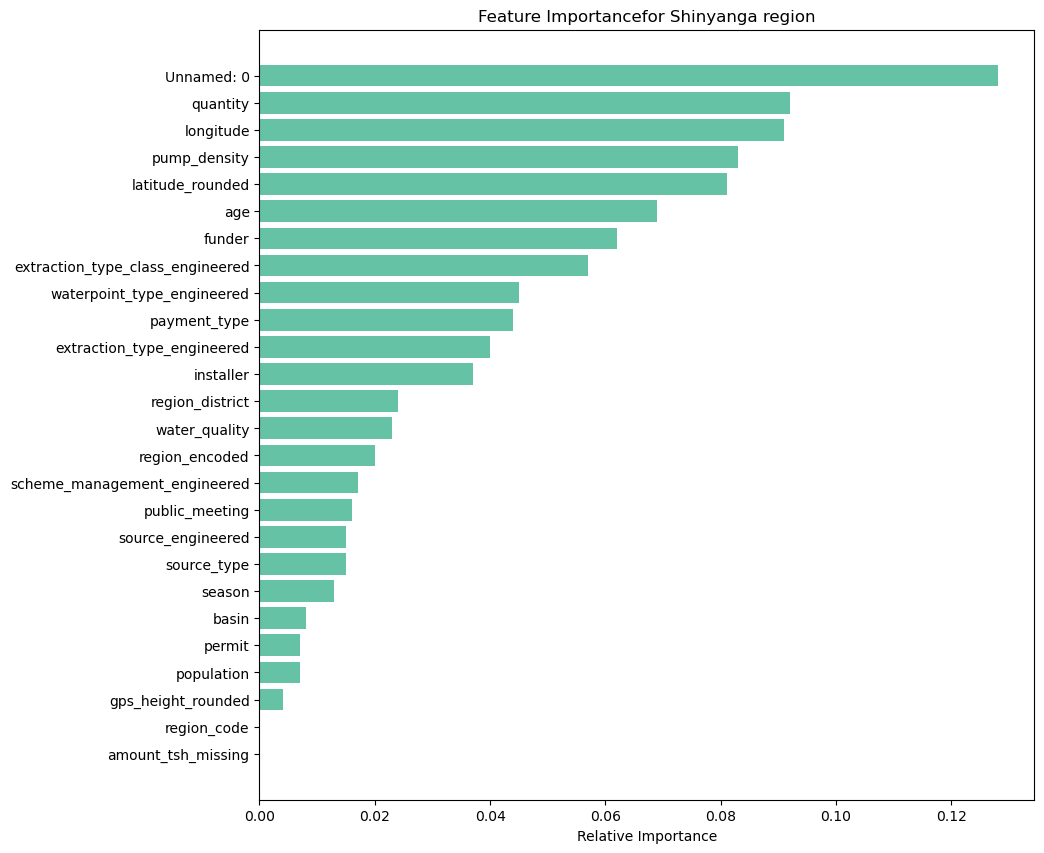

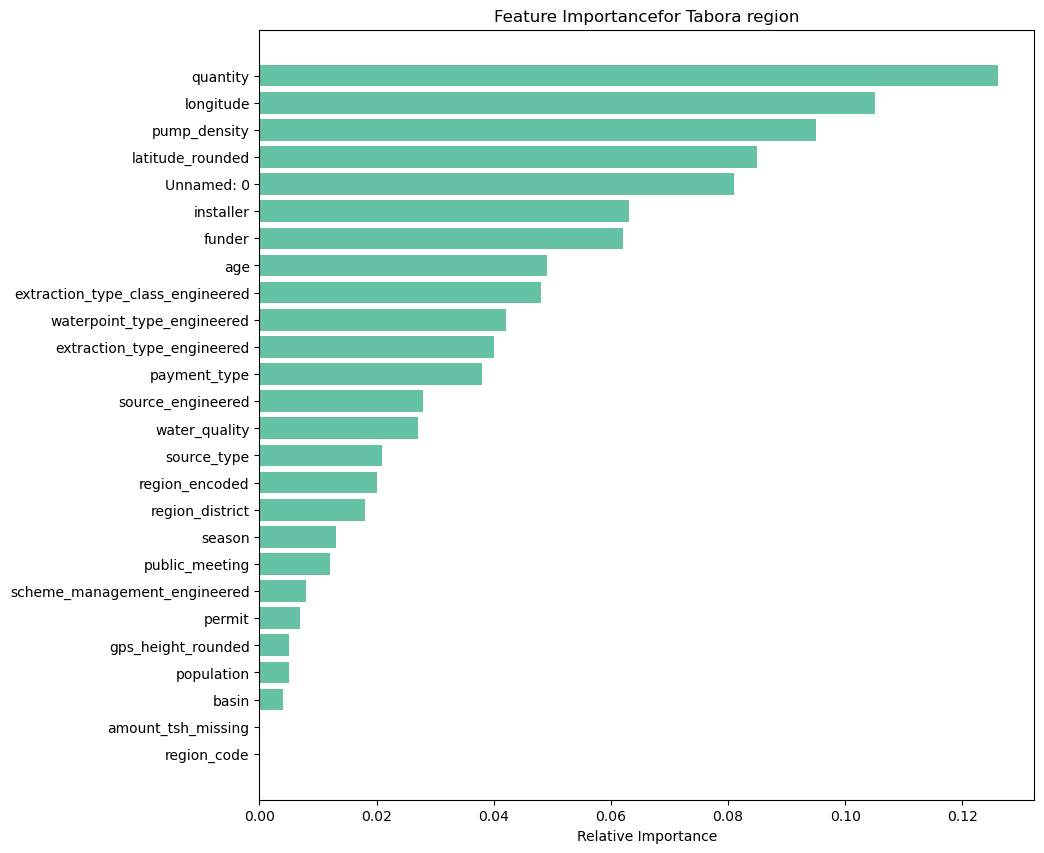

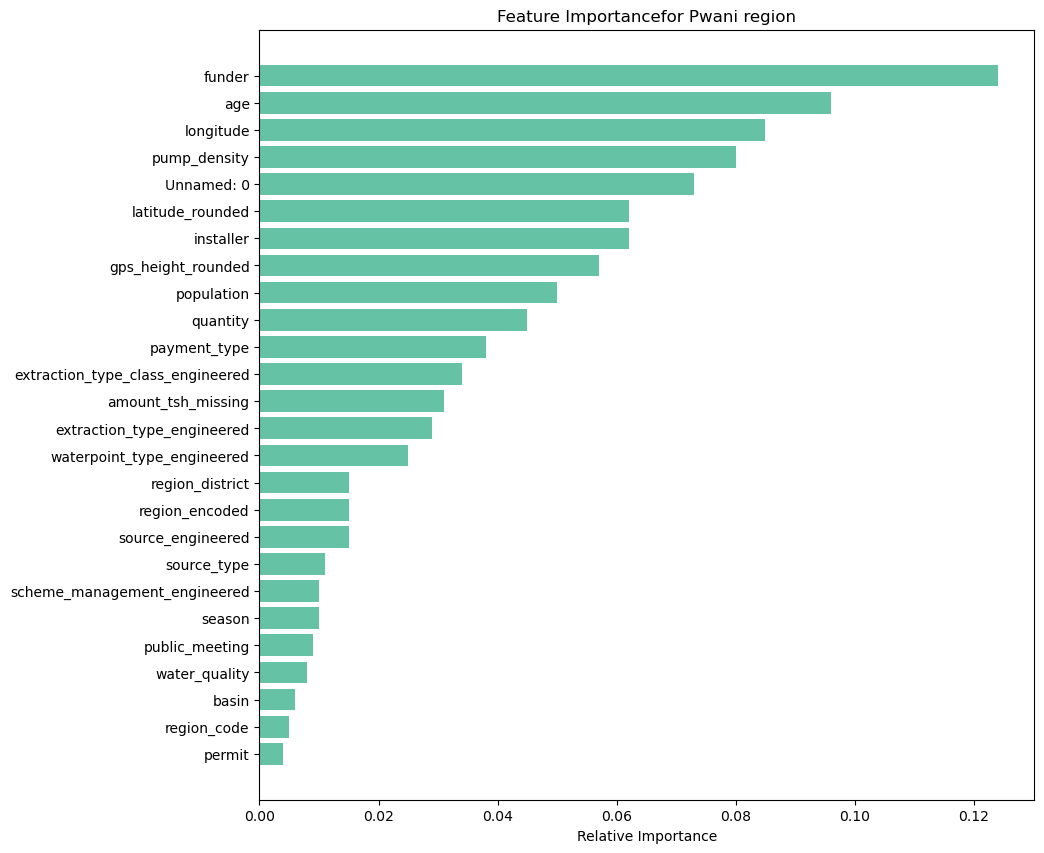

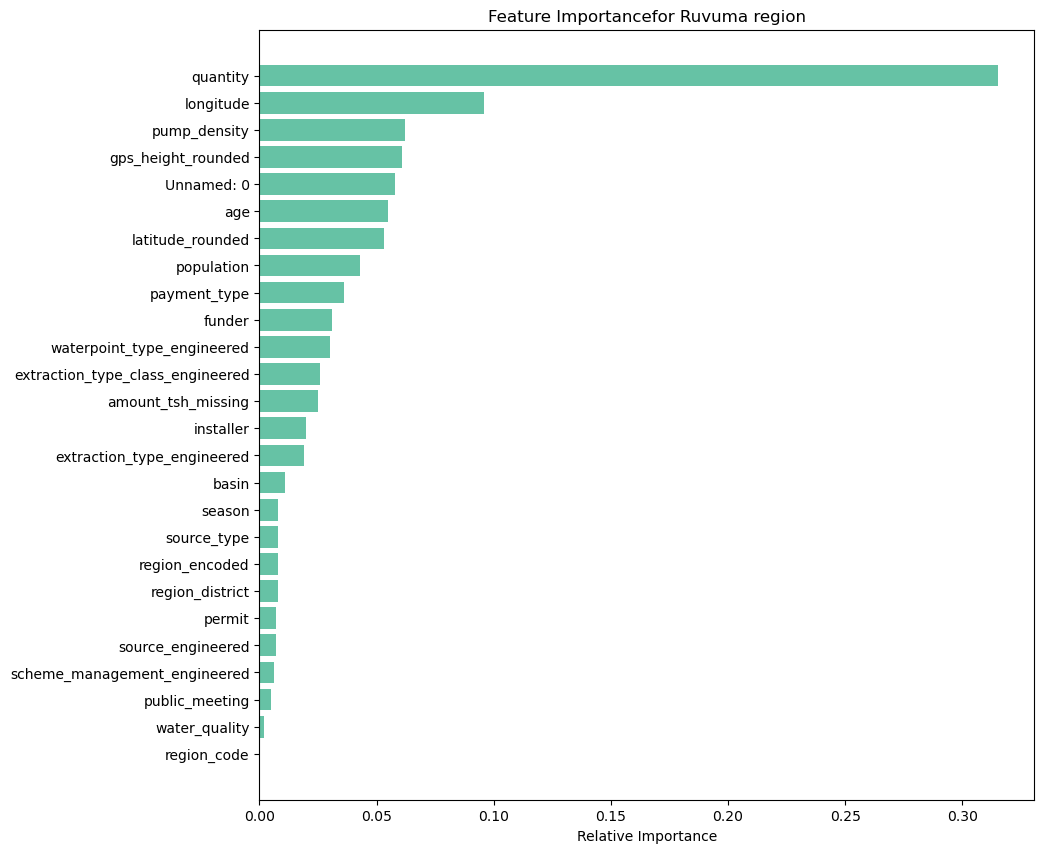

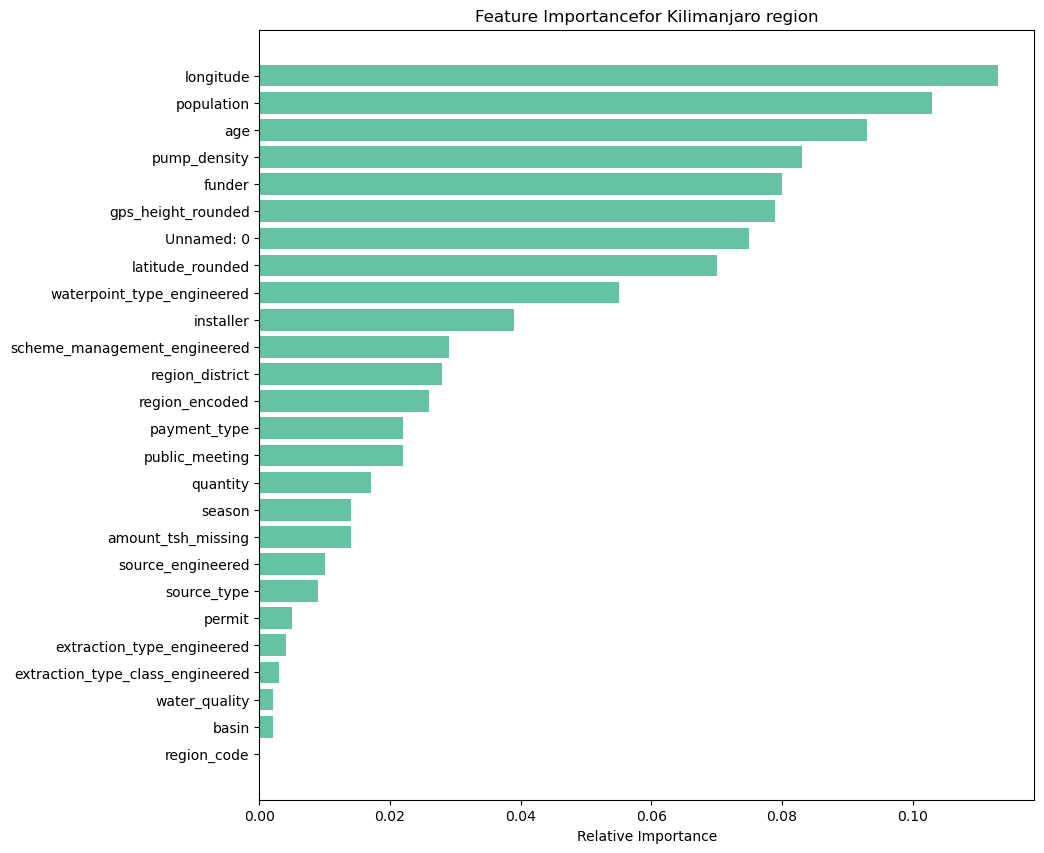

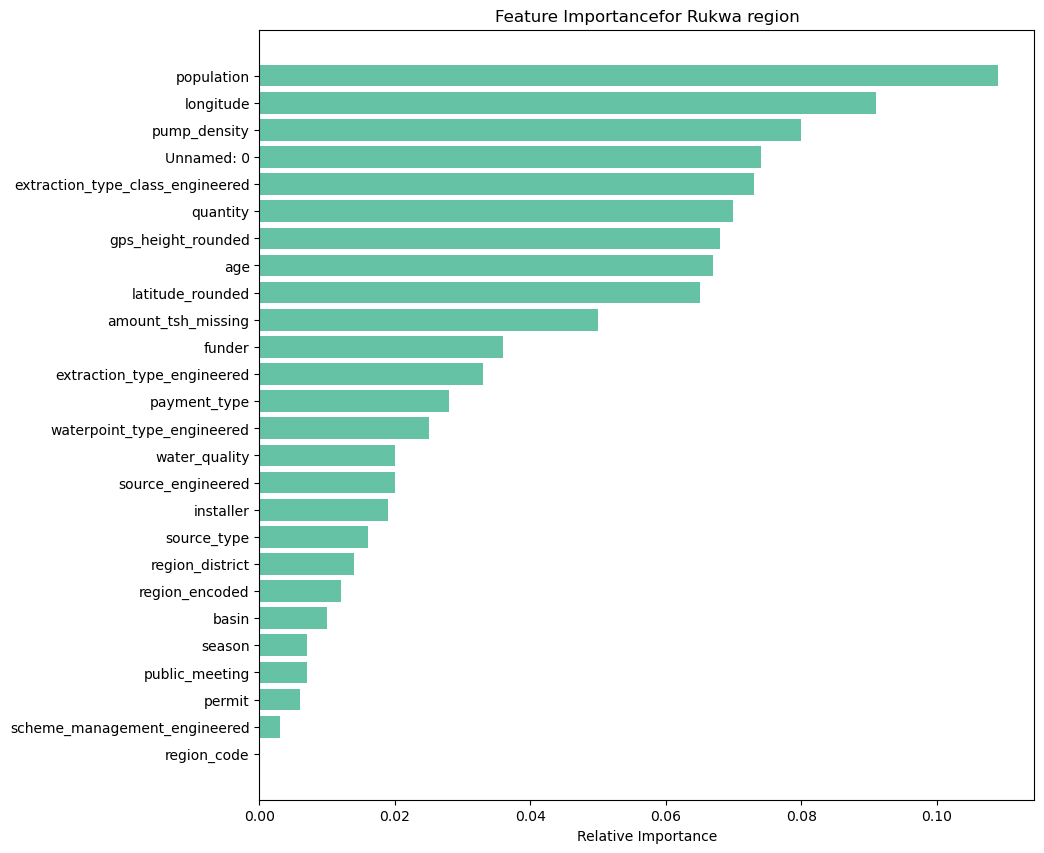

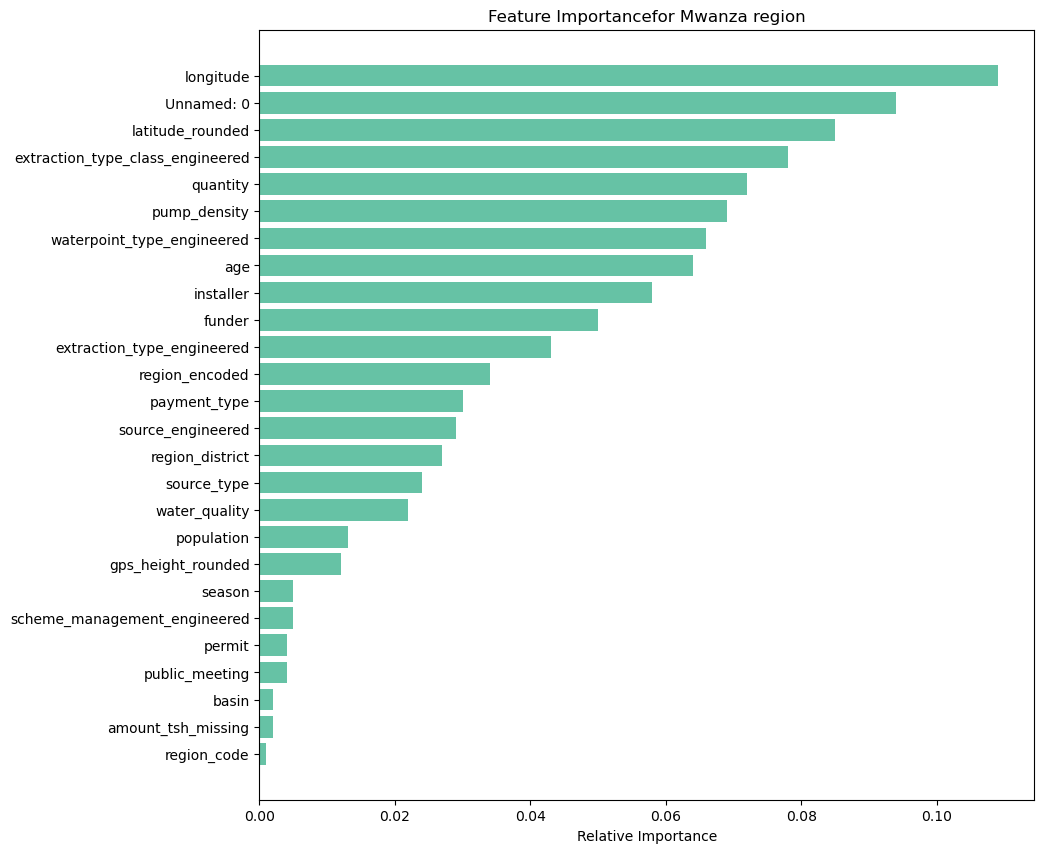

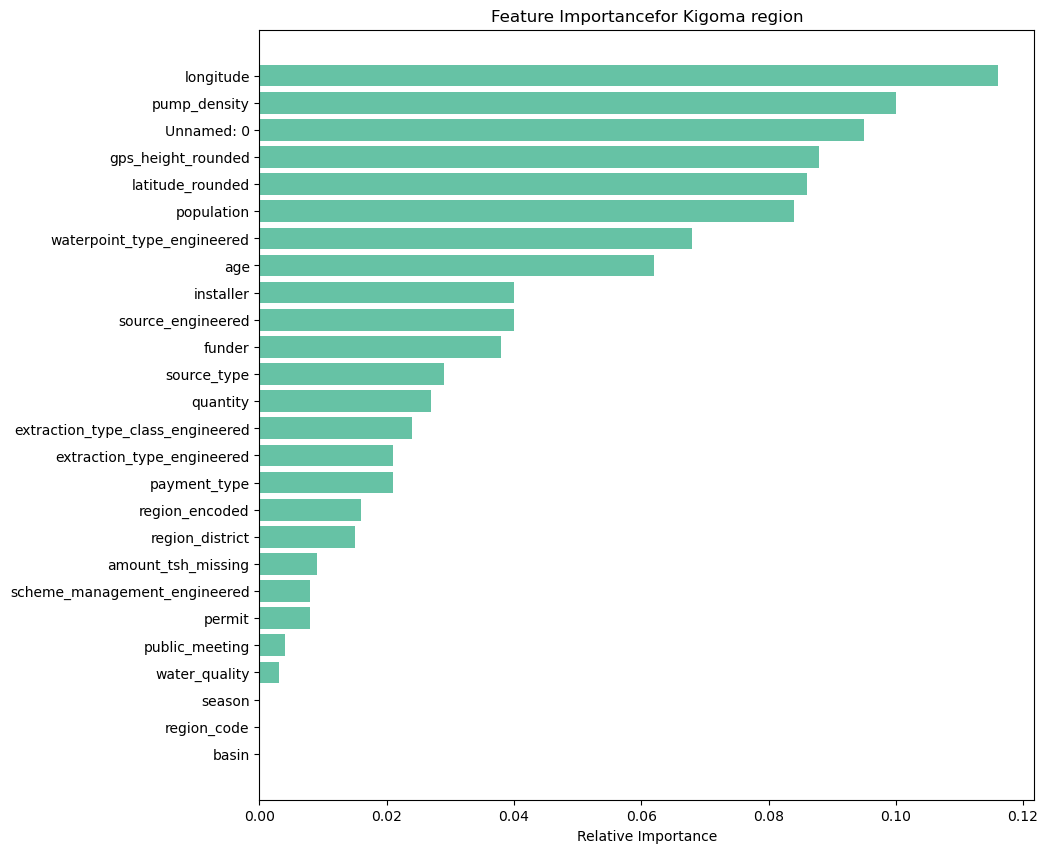

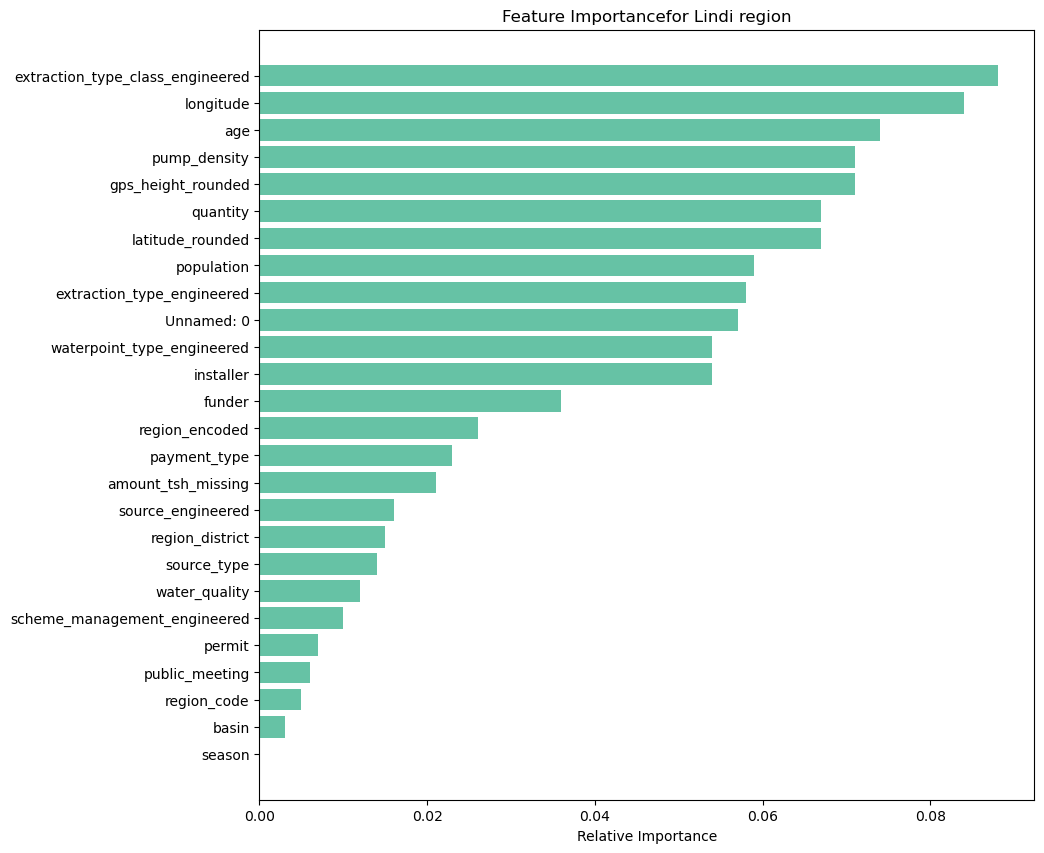

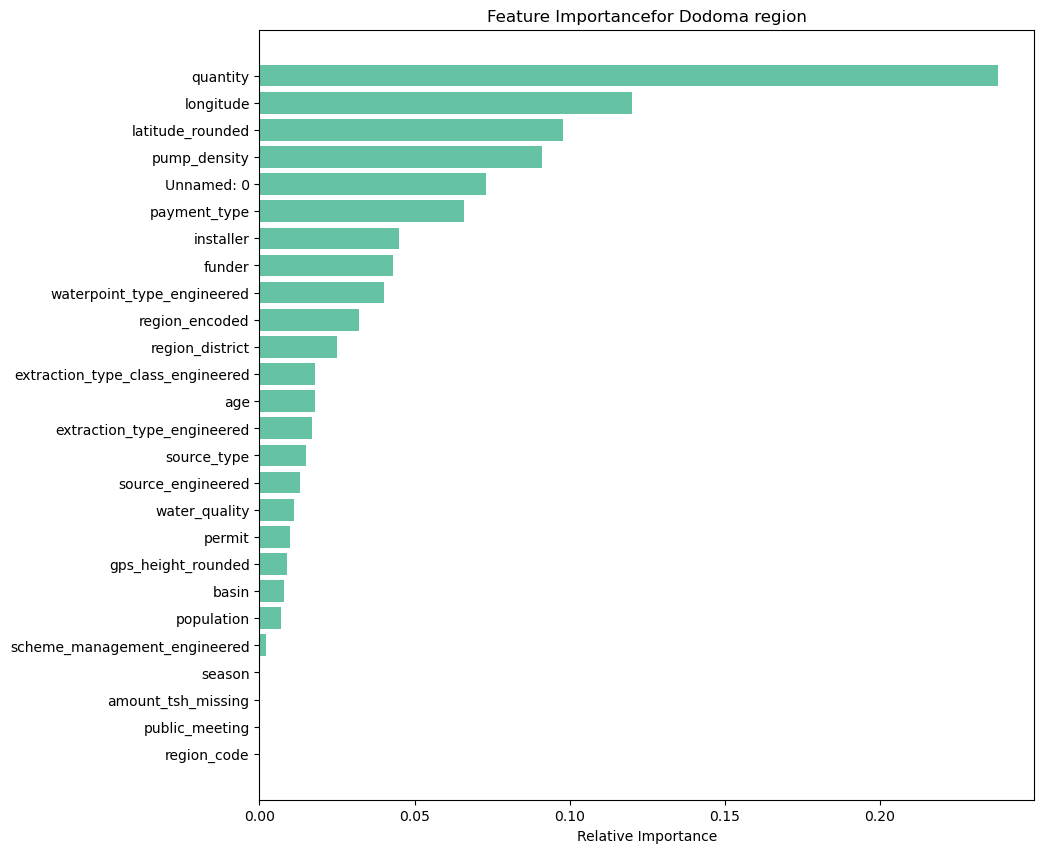

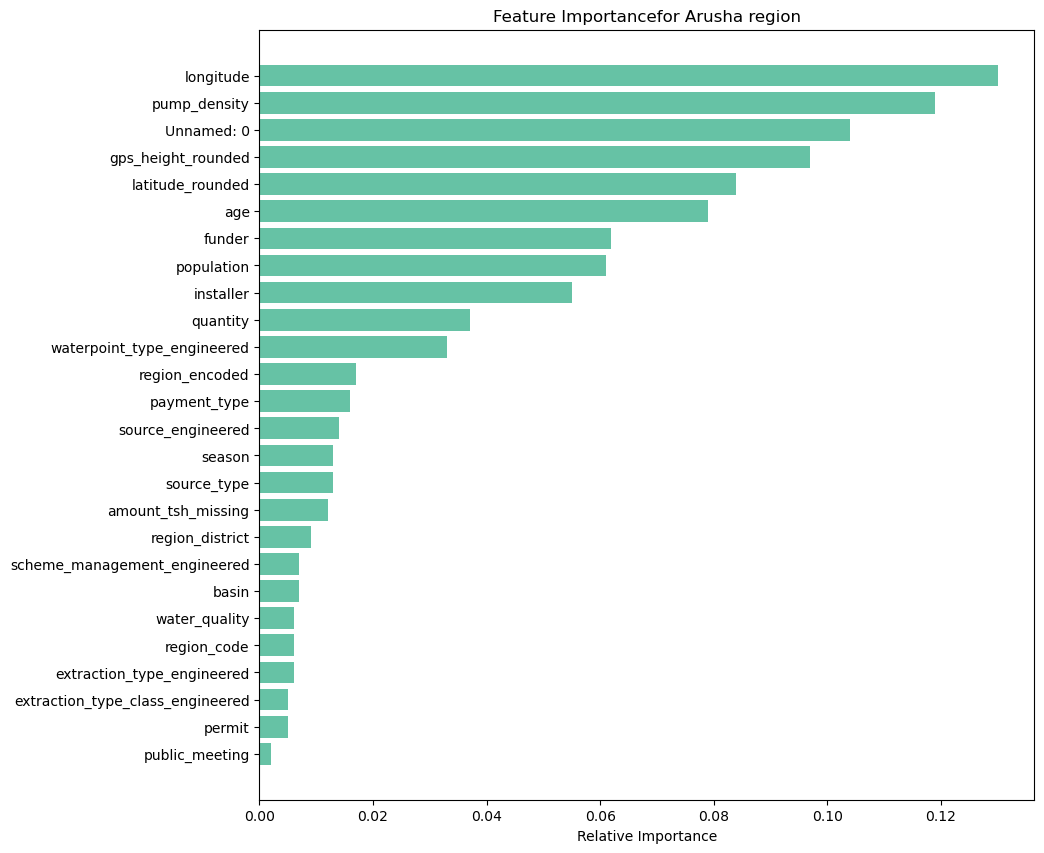

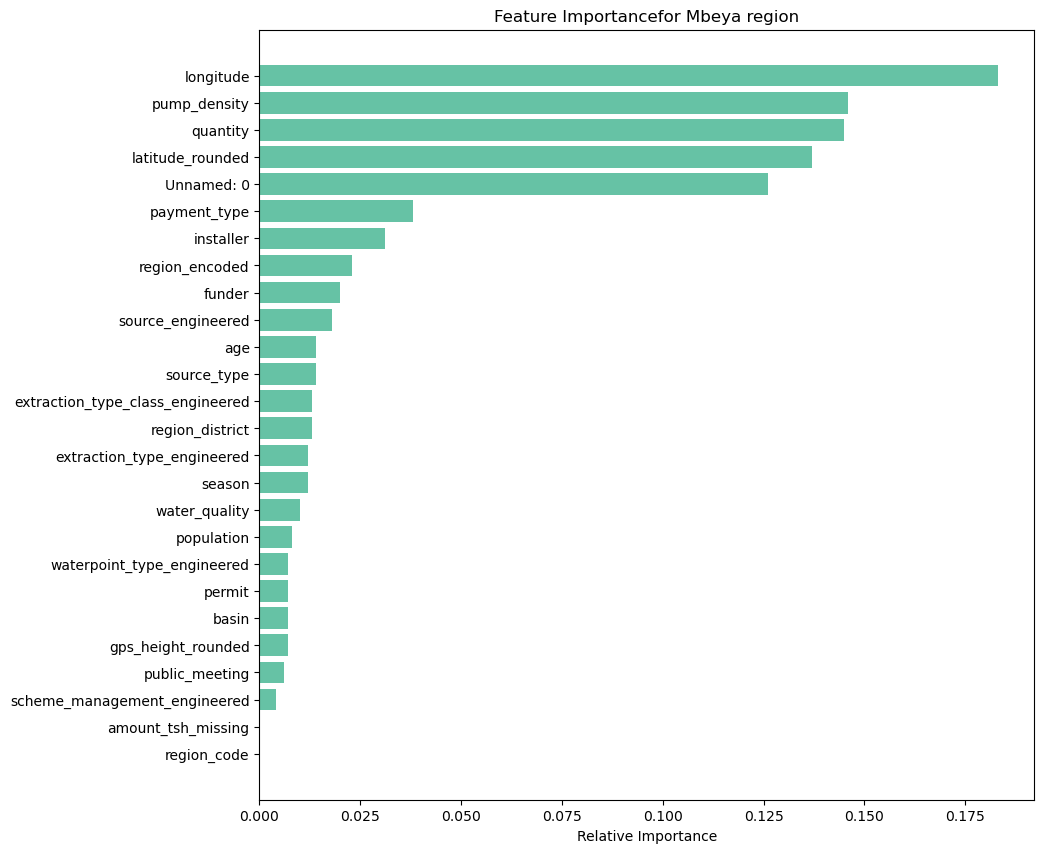

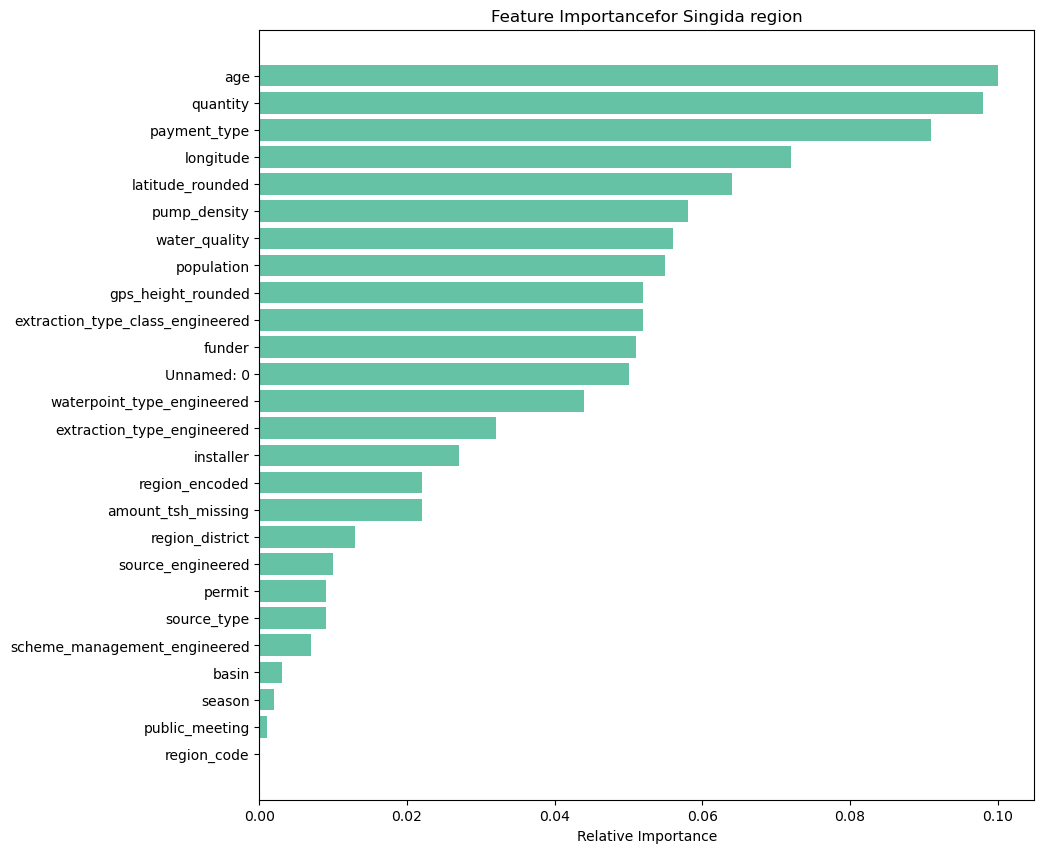

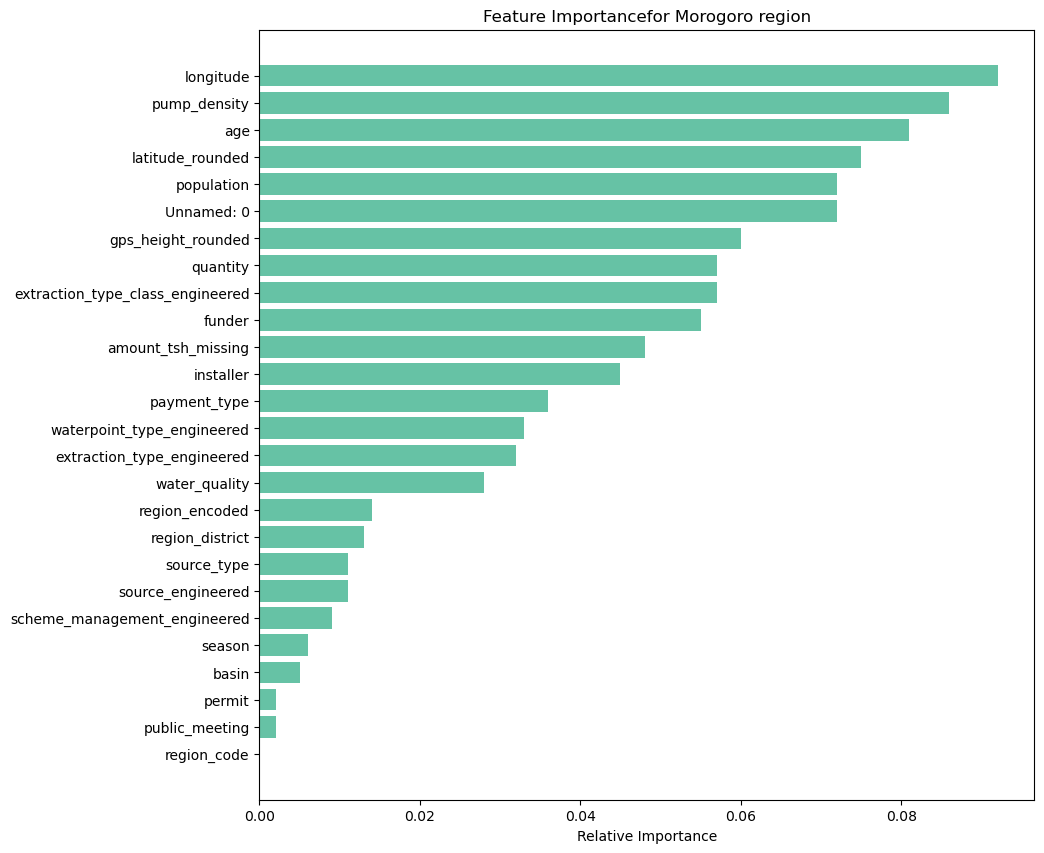

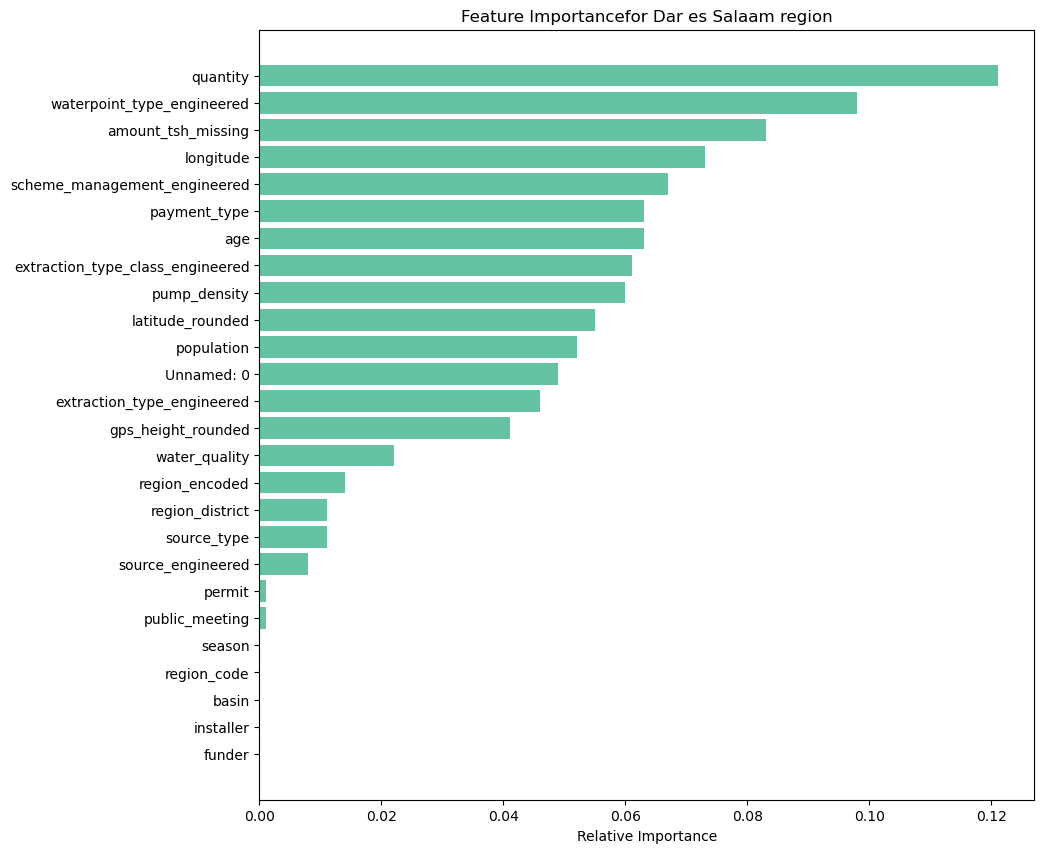

In [223]:
#instantiate model and cross_validation
rf = RandomForestClassifier(random_state =42)
cv = KFold(n_splits=10, shuffle = True,  random_state=1)

for region in train_df['region'].unique():

    df = train_df[train_df['region'] == region].drop('region', axis=1)

    #define train and test 
    train_set = df[df['status_group'].notna()]
    test_set = df[df['status_group'].isna()]

    #define X and y varaibles
    X = train_set.drop(['status_group', 'id'],axis=1)
    y = train_set['status_group']

    #perform cross-validaton
    n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

    # report performance
    print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

    #plot feature importance
    feature_importances(rf, "for "+region+" region")

In [224]:
original_df.columns

Index(['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder',
       'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name',
       'num_private', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [225]:
distribution_checker(original_df, 'region')#.sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
region,,,,,
Arusha,3350,5.6,68.5,26.3,5.2
Dar es Salaam,805,1.4,57.3,42.4,0.4
Dodoma,2201,3.7,45.8,44.7,9.5
Iringa,5294,8.9,78.2,19.5,2.3
Kagera,3316,5.6,52.1,38.8,9.2
Kigoma,2816,4.7,48.4,30.2,21.4
Kilimanjaro,4379,7.4,60.3,32.4,7.4
Lindi,1546,2.6,29.8,64.2,6.0
Manyara,1583,2.7,62.3,31.6,6.1


### Question 1 Conclusion

- Iringa: **`quantity`** >.3 `longitude` >.1 - `quantity`: enough water in most pumps (>80%). Iringa has very high functionality.
- Mara: `age`, `longitude` >.1
- Manyara: `quantity`, `population` >.1
- Mtwara: `quantity` >.1
- Kagera: `quantity`, `longitude`, `pump_density`, `latitude` >.1
- Tanga: `longitude`, `pump_density`, `latitude` >.1
- Shinyanga: `quantity`, `latitude` >.1
- Tabora: `quantity`, `longitude`, `pump_density` >.1
- Pwani: **`funder`**, `age` >.1 - `funder`: most pumps funded by private individual, and these have 90% functionaloty rate
- Ruvuma: **`quantity`** >.3 `longitude` >.1 - `quantity`: two times more dry pumps than usual
- Kilimanjaro: `longitude`, `population`, `age` >.1
- Rukwa: `population` >.1
- Mwanza: `longitude` >.1
- Kigoma: `longitude`, `pump_density` >.1
- Lindi: none >.1
- Dodoma: **`quantity`** >.3 `longitude`, `latitude`, `pump_density` >.1 - `quantity`: same as Ruvuma
- Arusha: `longitude`, `pump_density` >.1
- Mbeya: `longitude`, `pump_density`, `quantity`, `latitude` >.1
- Singida: `age`, `quantity` >.1
- Morogoro none >.1
- Salaam: `quantity`, `waterpoint_type` >.1

Geographic features seem to be important in general (even within separate regions). 'Population' and 'age' also appeared frequently on the top/

# Question 2

In [226]:
distribution_checker(original_df, 'scheme_management')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
scheme_management,,,,,
Company,1061,1.9,50.3,46.2,3.5
None,1,0.0,100.0,0.0,0.0
Other,766,1.4,59.8,37.3,2.9
Parastatal,1680,3.0,57.5,30.5,12.0
Private operator,1063,1.9,68.6,29.3,2.2
SWC,97,0.2,20.6,78.4,1.0
Trust,72,0.1,63.9,29.2,6.9
VWC,36792,66.3,51.5,42.1,6.3
WUA,2883,5.2,69.2,22.5,8.3


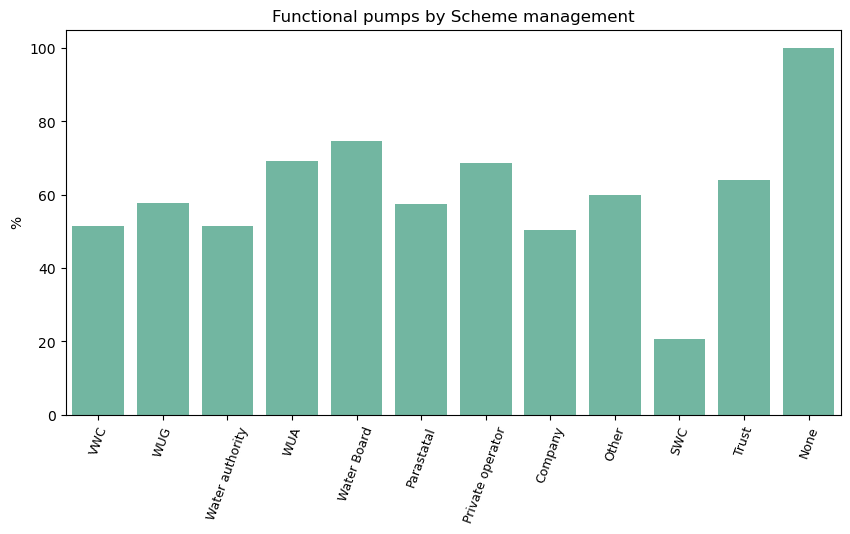

In [227]:
#percentage of functional pumps differs for different scheme management categories
fig, ax = plt.subplots(figsize=(10,5))
ax =sns.barplot(x = scheme.index, y = scheme['perc_functional'], color =  '#66c2a5')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, fontsize=9)
ax.set(title = 'Functional pumps by Scheme management', ylabel = '%', xlabel = "")
plt.show()

In [228]:
bad_list = ['SWC', 'Company']
good_list = ['Water Board', 'WUA', 'Private operator', 'Trust']

Accuracy: 0.763 (0.031)


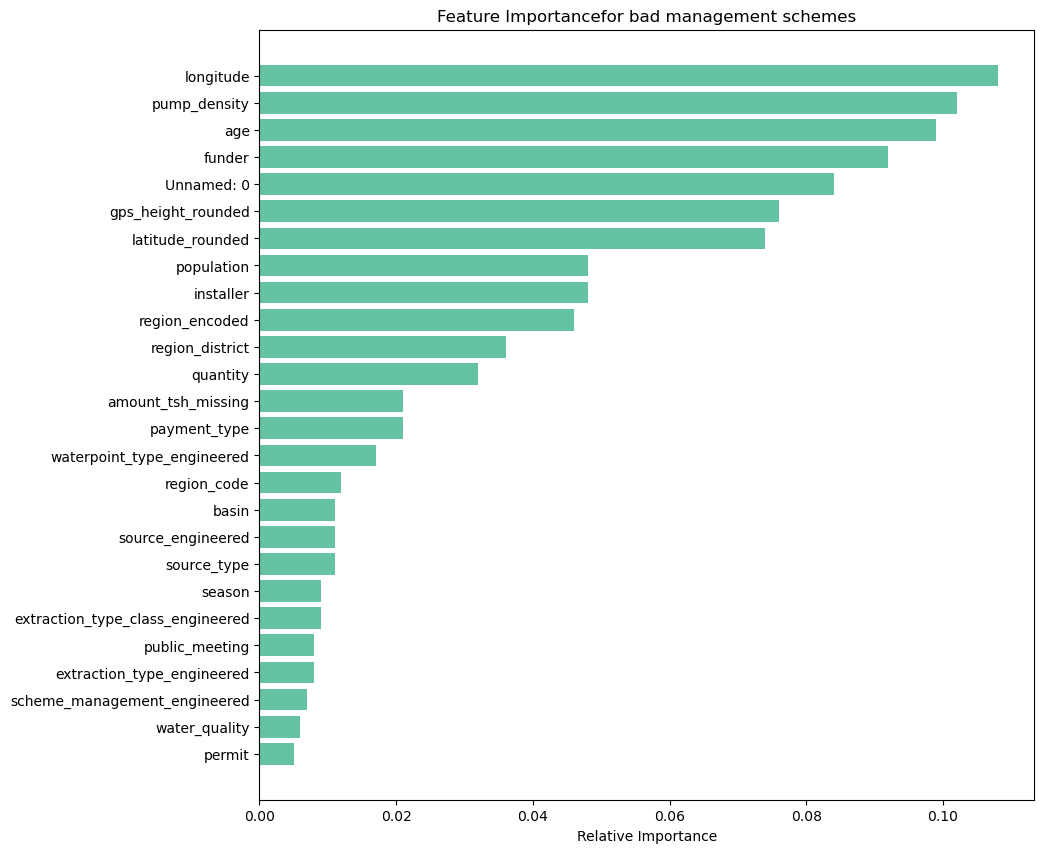

In [229]:
train_df = train_df.drop('region', axis=1)

#instantiate model and cross_validation
rf = RandomForestClassifier(random_state =42)
cv = KFold(n_splits=10, shuffle = True,  random_state=1)

df = train_df[full_df['scheme_management'].isin(bad_list)]

#define train and test 
train_set = df[df['status_group'].notna()]
test_set = df[df['status_group'].isna()]

#define X and y varaibles
X = train_set.drop(['status_group', 'id'],axis=1)
y = train_set['status_group']

#perform cross-validaton
n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#plot feature importance
feature_importances(rf, "for bad management schemes")

Accuracy: 0.850 (0.009)


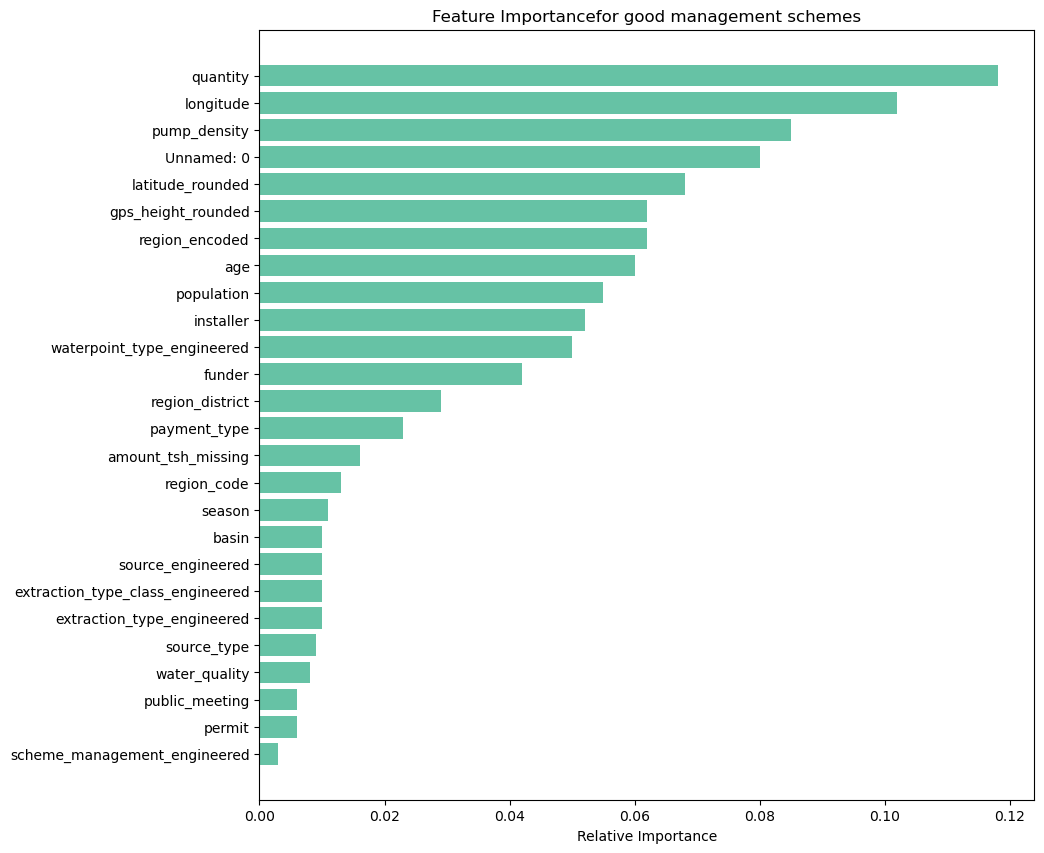

In [230]:
#instantiate model and cross_validation
rf = RandomForestClassifier(random_state =42)
cv = KFold(n_splits=10, shuffle = True,  random_state=1)

df = train_df[full_df['scheme_management'].isin(good_list)]

#define train and test 
train_set = df[df['status_group'].notna()]
test_set = df[df['status_group'].isna()]

#define X and y varaibles
X = train_set.drop(['status_group', 'id'],axis=1)
y = train_set['status_group']

#perform cross-validaton
n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#plot feature importance
feature_importances(rf, "for good management schemes")

In [231]:
#the use of submersible pumps is common for private operators
private = original_df[original_df['scheme_management'].isin(good_list)]
private_extraction = private.groupby('quantity')['id'].count().reset_index()
private_extraction['total_pumps'] =private_extraction['id'].sum()
private_extraction['percentage'] = round((private_extraction['id']/ private_extraction['total_pumps'])*100,1)
private_extraction = private_extraction.sort_values('percentage', ascending = False)
private_extraction = private_extraction.drop(['id', 'total_pumps'],axis=1)
private_extraction

,quantity,percentage
1,enough,68.0
2,insufficient,19.0
3,seasonal,6.2
0,dry,6.0
4,unknown,0.9


In [232]:
distribution_checker(original_df, 'quantity').sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
quantity,,,,,
enough,33185,55.9,65.2,27.5,7.2
insufficient,15129,25.5,52.3,38.1,9.6
dry,6246,10.5,2.5,96.9,0.6
seasonal,4050,6.8,57.4,32.3,10.3
unknown,789,1.3,27.0,71.2,1.8


In [233]:
# #define data
# data = private_extraction['percentage']
# labels = private_extraction['installer']

# #define Seaborn color palette to use
# colors = sns.color_palette('Set2')

# #create pie chart
# plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
# plt.legend(bbox_to_anchor=(1.5, 1), loc=2, borderaxespad=0.)
# plt.title("Private operator")
# plt.show()

In [234]:
#the use of submersible pumps is common for private operators
vwc = original_df[original_df['scheme_management'].isin(bad_list)]
vwc_extraction = vwc .groupby('quantity')['id'].count().reset_index()
vwc_extraction['total_pumps'] =vwc_extraction['id'].sum()
vwc_extraction['percentage'] = round((vwc_extraction['id']/ vwc_extraction['total_pumps'])*100,1)
vwc_extraction = vwc_extraction.sort_values('percentage', ascending = False)
vwc_extraction = vwc_extraction.drop(['id', 'total_pumps'],axis=1)
vwc_extraction

,quantity,percentage
1,enough,56.2
2,insufficient,37.3
0,dry,4.6
3,seasonal,1.8
4,unknown,0.1


### Q2 Conclusion

'Water Board', 'WUA', 'Private operator', 'Trust' have the highest functionality

'SWC' has a very large non-functionality (78%), but has only 97 samples
'Company' has second lowest (46%) with 1061 samples

Feature Importance analysis shown that quantity influences the functionality of water pumps with bad management schemes. There are almost twice as much pumps with insufficient quantity among the bad management schemes compared to quantity for good management schemes

# Question 3

In [235]:
original_df.columns

Index(['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder',
       'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name',
       'num_private', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [236]:
# check pump types with highest failures
distribution_checker(original_df, 'extraction_type_class').sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
extraction_type_class,,,,,
gravity,26780,45.1,59.9,30.0,10.1
handpump,16455,27.7,63.1,30.9,6.0
other,6430,10.8,16.0,80.8,3.2
submersible,6179,10.4,53.9,42.0,4.1
motorpump,2987,5.0,38.0,57.4,4.6
rope pump,451,0.8,65.0,31.3,3.8
wind-powered,117,0.2,42.7,51.3,6.0


In [237]:
bad_list = ['motorpump', 'other', 'wind-powered']
good_list = ['gravity', 'handpump', 'submersible', 'rope pump']

Accuracy: 0.902 (0.006)


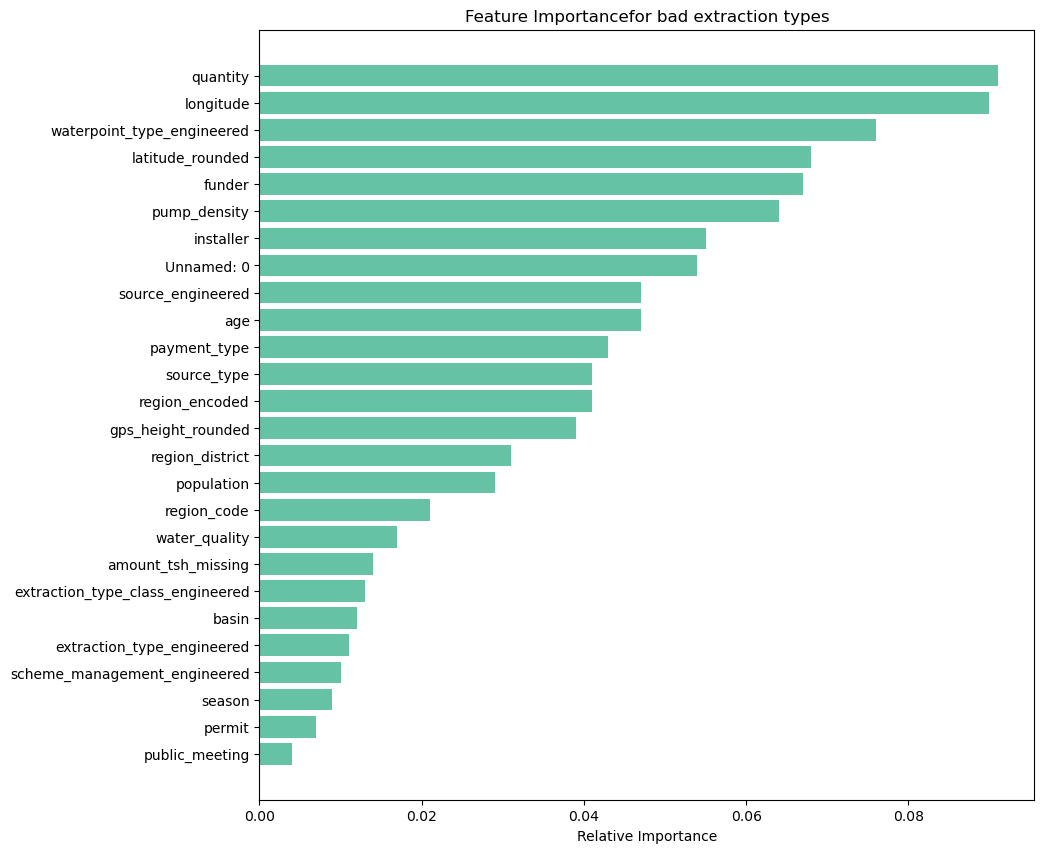

In [238]:
#instantiate model and cross_validation
rf = RandomForestClassifier(random_state =42)
cv = KFold(n_splits=10, shuffle = True,  random_state=1)

df = train_df[full_df['extraction_type_class'].isin(bad_list)]

#define train and test 
train_set = df[df['status_group'].notna()]
test_set = df[df['status_group'].isna()]

#define X and y varaibles
X = train_set.drop(['status_group', 'id'],axis=1)
y = train_set['status_group']

#perform cross-validaton
n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#plot feature importance
feature_importances(rf, "for bad extraction types")

Accuracy: 0.793 (0.006)


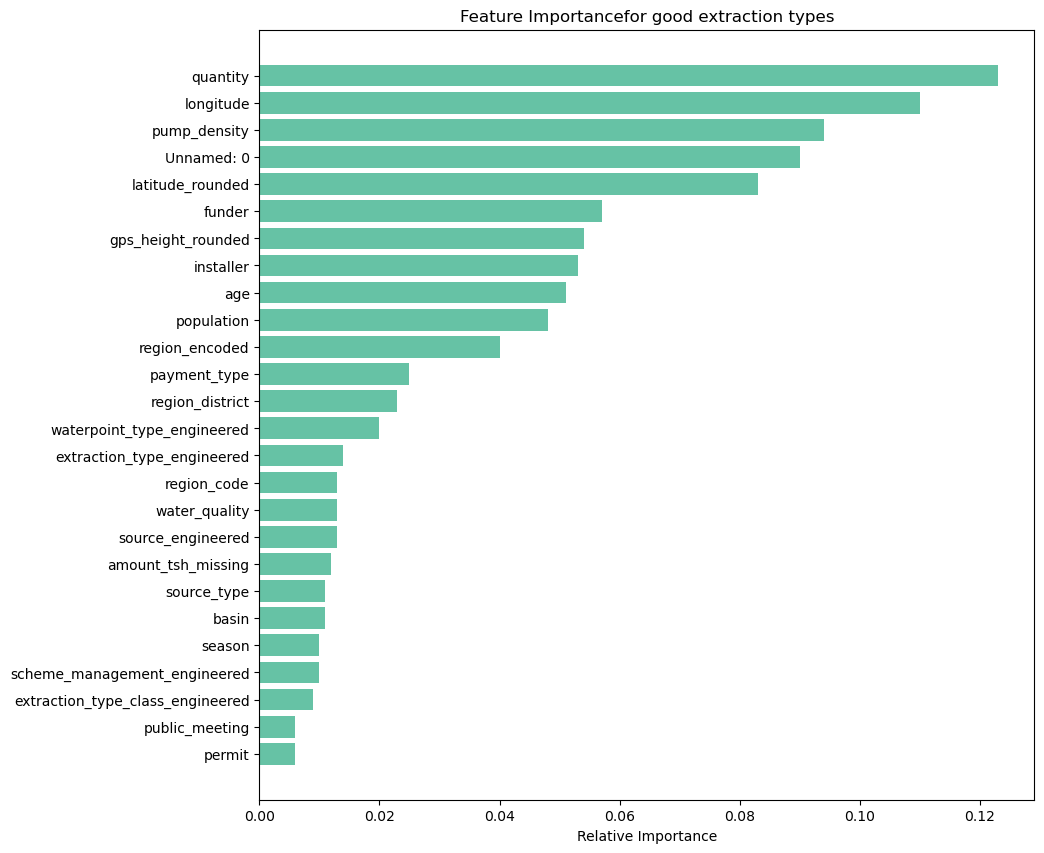

In [239]:
#instantiate model and cross_validation
rf = RandomForestClassifier(random_state =42)
cv = KFold(n_splits=10, shuffle = True,  random_state=1)

df = train_df[full_df['extraction_type_class'].isin(good_list)]

#define train and test 
train_set = df[df['status_group'].notna()]
test_set = df[df['status_group'].isna()]

#define X and y varaibles
X = train_set.drop(['status_group', 'id'],axis=1)
y = train_set['status_group']

#perform cross-validaton
n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#plot feature importance
feature_importances(rf, "for good extraction types")

`quantity` again

In [240]:
#the use of submersible pumps is common for private operators
private = original_df[original_df['extraction_type_class'].isin(good_list)]
private_extraction = private.groupby('quantity')['id'].count().reset_index()
private_extraction['total_pumps'] =private_extraction['id'].sum()
private_extraction['percentage'] = round((private_extraction['id']/ private_extraction['total_pumps'])*100,1)
private_extraction = private_extraction.sort_values('percentage', ascending = False)
private_extraction = private_extraction.drop(['id', 'total_pumps'],axis=1)
private_extraction

,quantity,percentage
1,enough,58.1
2,insufficient,25.7
0,dry,8.0
3,seasonal,7.0
4,unknown,1.1


In [241]:
#the use of submersible pumps is common for private operators
vwc = original_df[original_df['extraction_type_class'].isin(bad_list)]
vwc_extraction = vwc .groupby('quantity')['id'].count().reset_index()
vwc_extraction['total_pumps'] =vwc_extraction['id'].sum()
vwc_extraction['percentage'] = round((vwc_extraction['id']/ vwc_extraction['total_pumps'])*100,1)
vwc_extraction = vwc_extraction.sort_values('percentage', ascending = False)
vwc_extraction = vwc_extraction.drop(['id', 'total_pumps'],axis=1)
vwc_extraction

,quantity,percentage
1,enough,44.0
2,insufficient,24.5
0,dry,23.4
3,seasonal,5.7
4,unknown,2.4


In [242]:
# barplot of water quantity and pump type

# population and feature importance can be useful
distribution_checker(original_df, 'population').head(50)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
population,,,,,
1.0,7025,18.5,41.4,53.5,5.0
2.0,4,0.0,75.0,25.0,0.0
3.0,4,0.0,75.0,25.0,0.0
4.0,13,0.0,69.2,30.8,0.0
5.0,44,0.1,84.1,15.9,0.0
6.0,19,0.0,84.2,10.5,5.3
7.0,3,0.0,66.7,33.3,0.0
8.0,23,0.1,78.3,17.4,4.3
9.0,11,0.0,81.8,18.2,0.0


Accuracy: 0.811 (0.012)
Accuracy: 0.787 (0.009)
Accuracy: 0.843 (0.006)
Accuracy: 0.776 (0.011)
Accuracy: 0.780 (0.038)


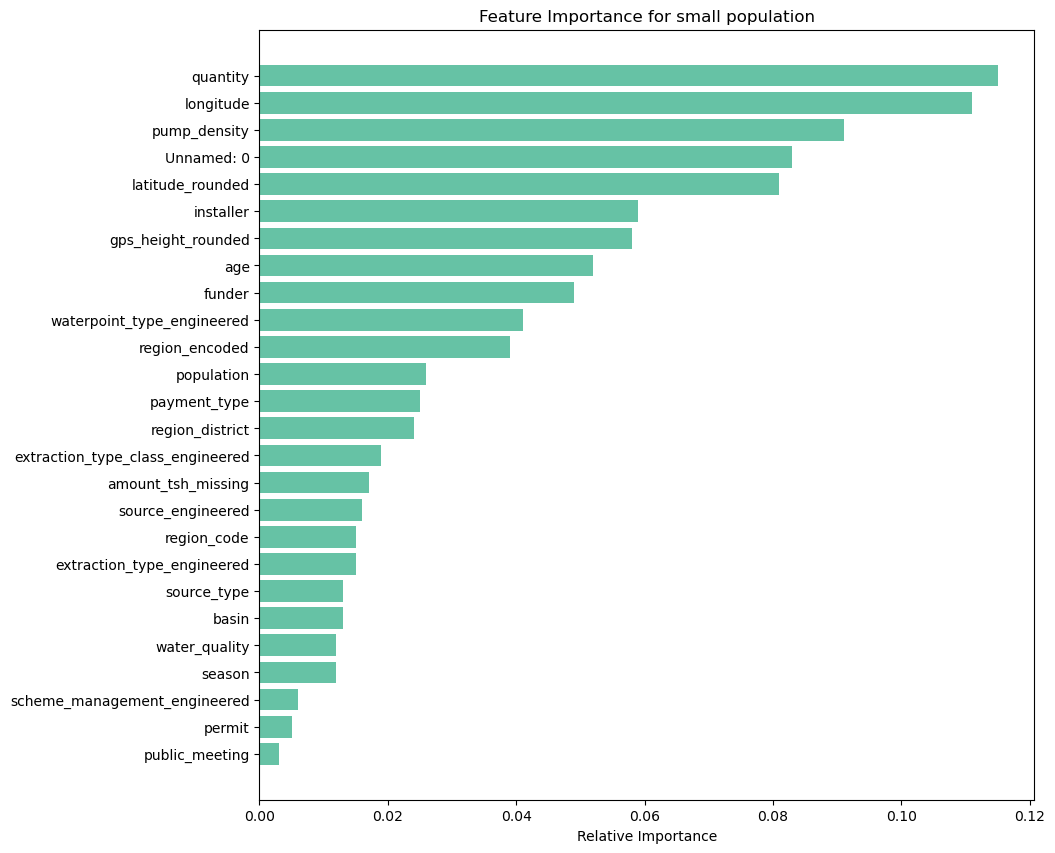

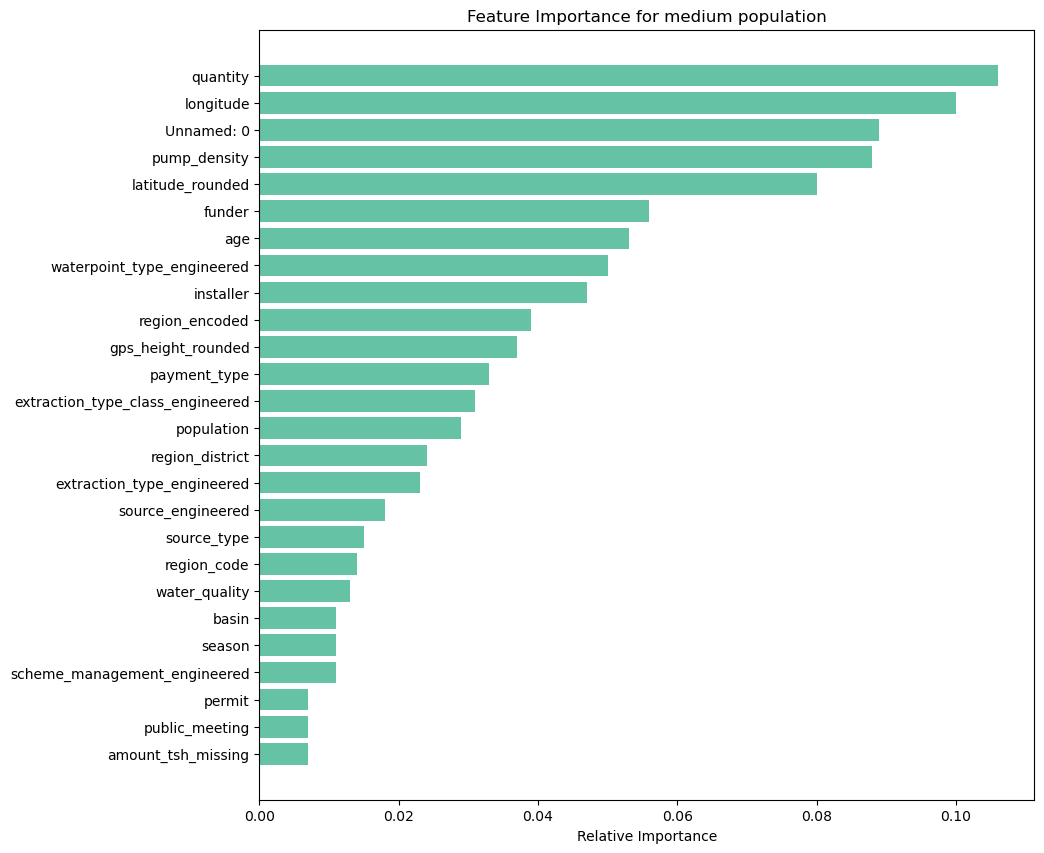

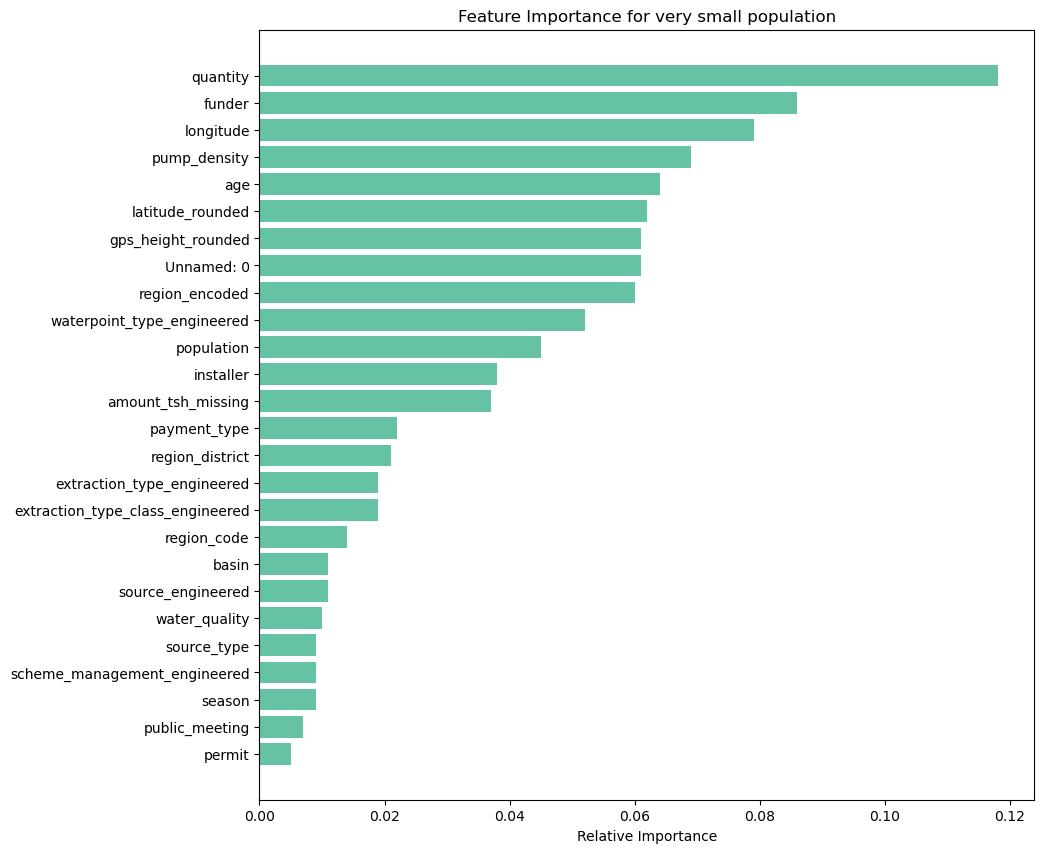

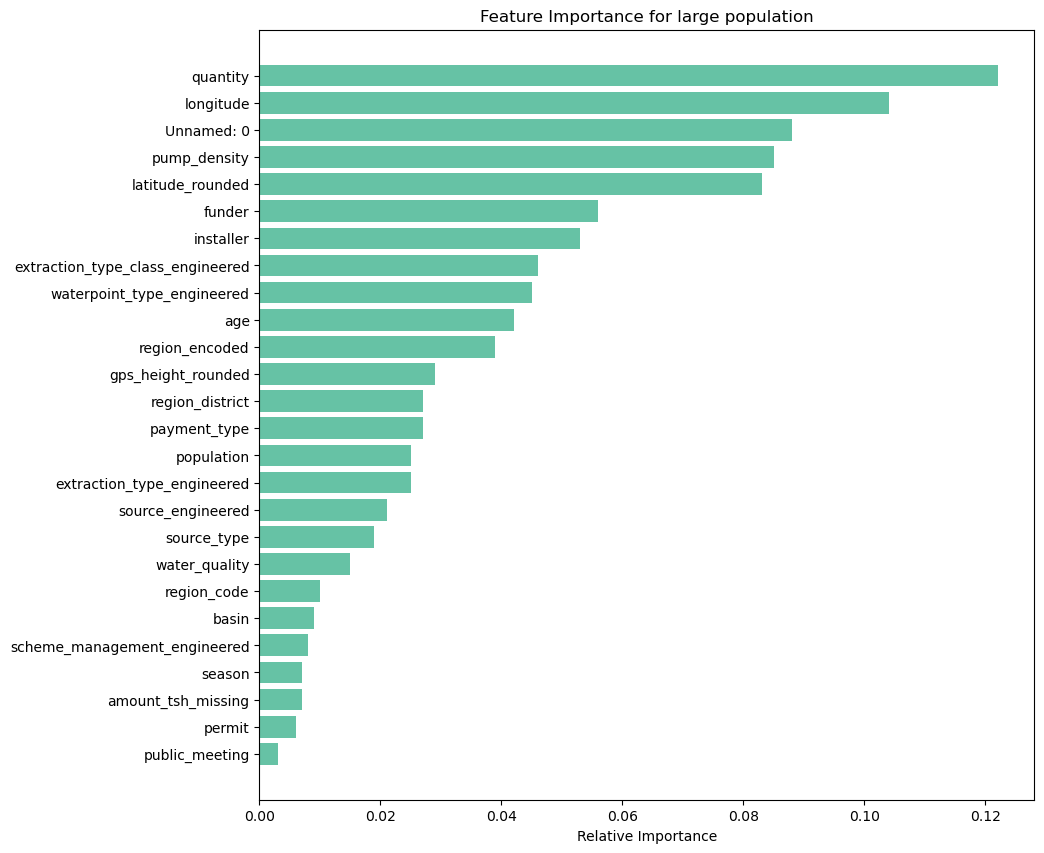

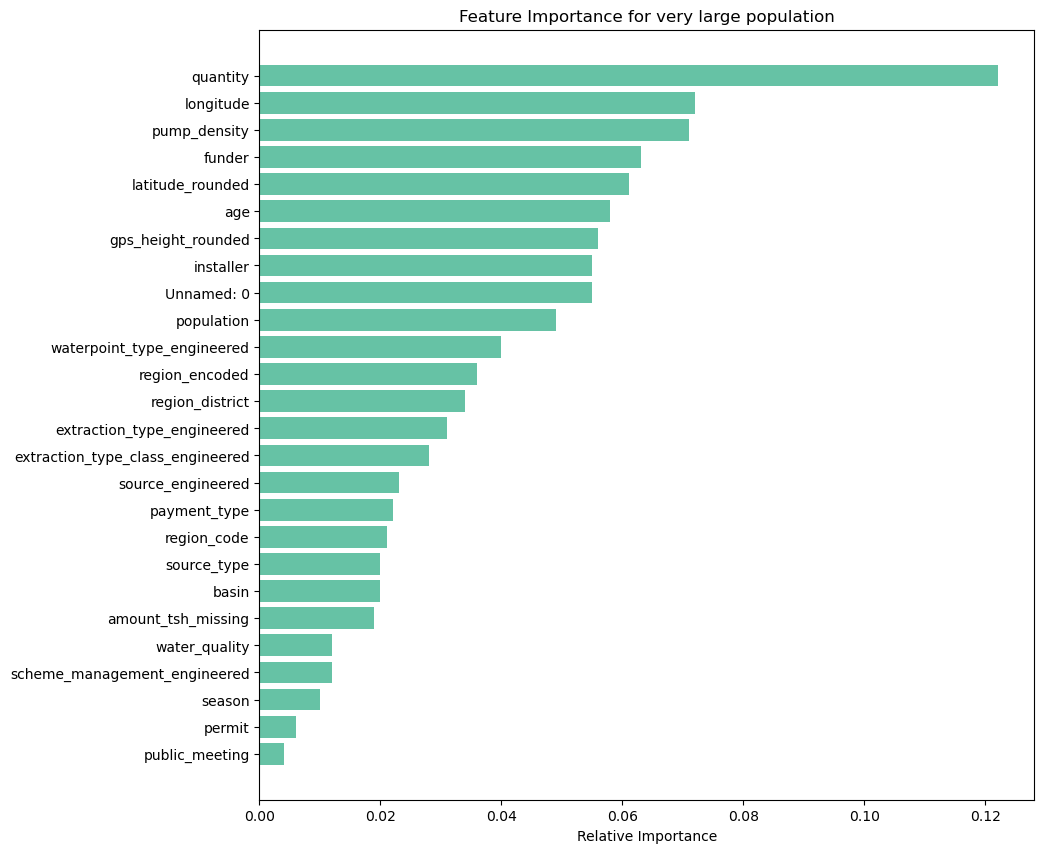

In [243]:
#instantiate model and cross_validation
rf = RandomForestClassifier(random_state =42)
cv = KFold(n_splits=10, shuffle = True,  random_state=1)

for pop in full_df['population_engineered'].unique():

    df = train_df[full_df['population_engineered'] == pop]

    #define train and test 
    train_set = df[df['status_group'].notna()]
    test_set = df[df['status_group'].isna()]

    #define X and y varaibles
    X = train_set.drop(['status_group', 'id'],axis=1)
    y = train_set['status_group']

    #perform cross-validaton
    n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

    # report performance
    print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

    #plot feature importance
    feature_importances(rf, " for "+pop+" population")

### Question 3 conclusion

most of labelled types have good functionality rate except for "motorpumps". "wind-powered" not great, but there are just 117 of them. "other" pumps are terrible and there make 10% of all pumps

This issue also comes down to water `quantity`. It seems like the feature that has the most important feature making extraction types perform badly are dry pumps. Extraction types with good functionality have 58% 'enough' `quantity` and 8% 'dry' `quantity`, while the ones with bad functionality have 44% 'enough' `quantity` and 23.4% 'dry' `quantity`.

One interesting feature is funder. It seems to be more important for very small population than for other bins. That might be caused by the "1" values (not sure in what way though).

# Question 4

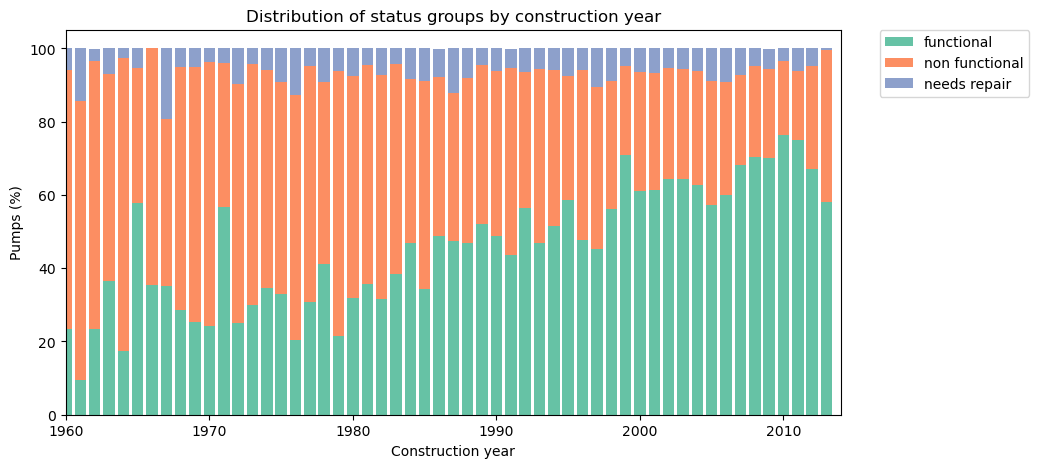

In [244]:
#import data
train_labels = pd.read_csv('project/data/train/labels.csv')
train_values = pd.read_csv('project/data/train/features.csv', parse_dates = ['date_recorded' ])
test_values = pd.read_csv('project/data/test/test.csv', parse_dates = ['date_recorded' ])

#merge train values and train labels to single dataset
train= pd.merge(train_labels , train_values, on='id')

#concatenate train and test for data visualization
raw = pd.concat([train, test_values])
raw.head()

#newer pumps tend to be more functional
fig, ax = plt.subplots(figsize=(10,5))
construction = distribution_checker(raw, 'construction_year')
labels = raw['construction_year'].sort_values().unique()
ax.bar(labels, construction['perc_functional'], label = 'functional',  color = '#66c2a5')
ax.bar (labels, construction['perc_non_functional'], label = 'non functional', bottom = construction['perc_functional'] , color = '#fc8e62')
ax.bar(labels, construction['perc_functional_needs_repair'], label = 'needs repair', bottom = construction['perc_functional'] + construction['perc_non_functional'],  color = '#8da0cb')
ax.set(title = 'Distribution of status groups by construction year', xlabel = 'Construction year', ylabel = 'Pumps (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([1960,2014])
plt.show()

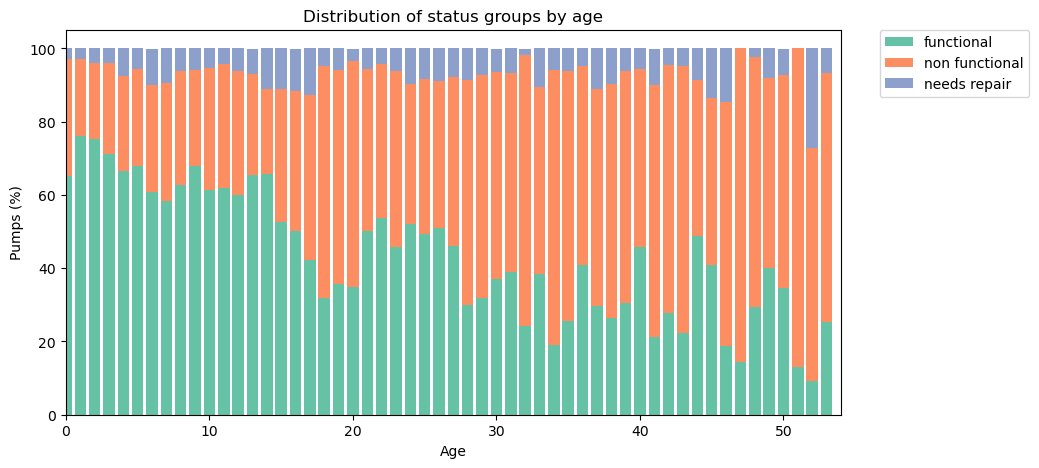

In [245]:
#newer pumps tend to be more functional
fig, ax = plt.subplots(figsize=(10,5))
construction = distribution_checker(full_df, 'age')
labels = full_df['age'].sort_values().unique()
ax.bar(labels, construction['perc_functional'], label = 'functional',  color = '#66c2a5')
ax.bar (labels, construction['perc_non_functional'], label = 'non functional', bottom = construction['perc_functional'] , color = '#fc8e62')
ax.bar(labels, construction['perc_functional_needs_repair'], label = 'needs repair', bottom = construction['perc_functional'] + construction['perc_non_functional'],  color = '#8da0cb')
ax.set(title = 'Distribution of status groups by age', xlabel = 'Age', ylabel = 'Pumps (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([0, 54])
plt.show()

In [246]:
distribution_checker(full_df, 'age')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
age,,,,,
-7,1,0.0,100.0,0.0,0.0
-5,3,0.0,66.7,33.3,0.0
-4,2,0.0,50.0,50.0,0.0
-3,1,0.0,0.0,100.0,0.0
-2,1,0.0,0.0,100.0,0.0
-1,1,0.0,0.0,100.0,0.0
0,701,1.2,65.3,31.8,2.9
1,2303,3.9,76.2,21.0,2.9
2,2130,3.6,75.2,20.8,4.1


### Question 4 conclusion

There is a pattern. It's less clear in the old pumps because there is much less of them.